In [2]:
import sys, os
sys.path.append('..')

from Data.TimeSeries import *

from Data.TimeSeries import *
import pandas as pd
import matplotlib

import cvxopt as opt
from cvxopt import blas, solvers

import numpy as np
import zipline
from zipline.api import (add_history, history, set_slippage,
                         slippage, set_commission, commission,
                         order_target_percent, symbol,symbols, record)


from zipline import TradingAlgorithm
from ETF.AAA import AAA
from ML.Features import *
from ML.Targets import *

import matplotlib.pyplot as plt

%matplotlib inline

/Users/jianboxue/anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [3]:
class TestNN(AAA) :

    params = {}
    train_win = 0
    nn_win = 0
    ml = 'SVM'
    atr = []
    enable_stoploss = False

    def set_params(self, t_win, n_win, ml='SVM', stoploss=False, rsi=False, vol=False) :
        self.train_win = t_win
        self.nn_win = n_win
        self.ml = ml
        self.atr_len = self.train_win
        self.enable_stoploss = stoploss
        self.enable_RSI = rsi
        self.enable_VOL = vol
        return self

    '''
    Using the last N days price directions as the features
    Target using the next day price direction
    '''
    def create_features(self, df, n = 5) :
        df_target = target_direction(df, 1)
        df_target.columns = ['target']

        list_df_features = []
        for i in xrange(n):
            list_df_features.append(direction(df, i+1))

        df_features = pd.DataFrame()
        for l in list_df_features:
            df_features = df_features.join(l, how='outer')

        if self.enable_RSI:
            df_features['RSI_3'] = ta.RSI(df.values.ravel(), n-1)
            # df_features['RSI_3'] = (ta.RSI(df.values.ravel(), n) > 50) * 1

        if self.enable_VOL:
            df_features['Std'] = pd.rolling_std(df, n-1)

        # adding the target
        df_features = df_features.join(df_target, how='outer')
        #df_features.dropna(inplace=True)

        return df_features.iloc[:, :-1], df_features.iloc[:, [-1]]

    def initialize(self, context):
        add_history(200, '1d', 'price')
        set_slippage(slippage.FixedSlippage(spread=0.0))
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
        context.tick = 0

        dp_data = self.data
        df_data = pd.DataFrame(index=dp_data.axes[1])
        df_data['close'] = dp_data[:, :, 'close']
        df_data['open'] = dp_data[:, :, 'open']
        df_data['high'] = dp_data[:, :, 'high']
        df_data['low'] = dp_data[:, :, 'low']
        df_data['volume'] = dp_data[:, :, 'volume']

        self.atr = atr_per_close(df_data, atrLen = self.atr_len)
        context.longstop = 0

    def handle_data(self, context, data):

        context.tick += 1
        total_window = self.train_win + self.nn_win + 1

        if context.tick < (total_window):
            return

        try :
#             print 'tick = {t}'.format(t = context.tick)
            price = history(total_window - 1, '1d', 'price').dropna()
            df_price = pd.DataFrame(data=price.values, index=price.index, columns=['close'])

            features, target = self.create_features(df_price, self.nn_win)
            features_insample = features.iloc[(self.nn_win -1):-1, :].values
            target_insample = target.iloc[(self.nn_win -1):-1, :].values.ravel()

            features_oosample = features.iloc[-1, :]
            features_oosample = features_oosample.values.reshape([1, len(features_oosample)])

            ATR = self.atr.loc[price.index[-1], :][0]

            symbol = price.columns[0]


            if self.enable_stoploss:
                if data[symbol].price < context.longstop:
                    print 'Stop Loss '
                    order_target_percent(symbol, 0.0)
                    context.longstop = 0.0
                    return

            if self.ml == 'SVM' :
                ### Training the SVM
                from sklearn import svm
                model_svm = svm.SVC()
                model_svm.fit(features_insample, target_insample)

                preds_svm = model_svm.predict(features_oosample)[0]
                if preds_svm < 0.5:
                    #print "Sell "
                    order_target_percent(symbol, 0.0)
                    context.longstop = 0.0

                else :
                    #print "Buy"
                    order_target_percent(symbol, 1.0)
                    context.longstop = max(context.longstop, data[symbol].price * (1 - 0.7*ATR))
                    print "target sl = {n}".format(n=context.longstop)

            if self.ml == 'KNN' :
                ### Training the SVM
                from sklearn import neighbors
                k = 10

                model_knn = neighbors.KNeighborsClassifier(k, 'distance')
                model_knn.fit(features_insample, target_insample)

                preds_knn = model_knn.predict(features_oosample)[0]

                if preds_knn < 0.5:
                    #print "Sell "
                    order_target_percent(symbol, 0.0)
                else :
                    #print "Buy"
                    order_target_percent(symbol, 1.0)

            record('price', data[symbol]['price'])
        except :
            pass

In [4]:
class ML :
    params = {}
    data = {}
    ml_model = None
    
    def __init__(self, params):
        self.params = params.copy()
        
    def set_params(self, params) :
        pass
    
    def load_features() :
        pass
    
    def train():
        pass
    
    def predict_last():
        pass
    
class ML_NN(ML) :
    def get_features(self, data):
        df = data[['close']]
        neighbor_len = self.params.get('Neighbor_Len')
        rsi_len = self.params.get('Rsi_Len')
        vol_len = self.params.get('Vol_Len')
        
        df_target = target_direction(df, 1)
        df_target.columns = ['target']

        list_df_features = []
        for i in xrange(neighbor_len):
            list_df_features.append(direction(df, i+1))

        df_data = pd.DataFrame()
        for l in list_df_features:
            df_data = df_data.join(l, how='outer')

        if rsi_len is not None:
            df_data['RSI_3'] = ta.RSI(df.values.ravel(), rsi_len)
            # df_features['RSI_3'] = (ta.RSI(df.values.ravel(), n) > 50) * 1

        if vol_len is not None:
            df_data['Std'] = pd.rolling_std(df, vol_len)

        # adding the target
        df_data = df_data.join(df_target, how='outer')
        #df_features.dropna(inplace=True)
    
        df_features_last = df_data.iloc[-1, :-1]
        
        df_data = df_data.dropna()
        df_features = df_data.iloc[:, :-1]
        df_target = df_data.iloc[:, [-1]]
        
        features = df_features.values
        target = df_target.values.ravel()
        features_last = df_features_last.values.reshape([1, len(df_features_last)])
        
        data_output = {'features': features, 'target': target, 'features_last': features_last}

        return data_output
    
    def train(self, features, target):
        model_name = self.params.get('ML_Model')
        if model_name is None:
            print "Please specify a machine learning model"
            return
        
        if model_name == 'KNN' :
            from sklearn import neighbors
            k = 10
            self.ml_model = neighbors.KNeighborsClassifier(k, 'distance')
        if model_name == 'SVM' :
            from sklearn import svm
            self.ml_model = svm.SVC()

        self.ml_model.fit(features, target)
        
        return self
        
    def predict(self, features_oos) :
        preds = self.ml_model.predict(features_oos)
        return preds

class ML_NextRet(ML) :
    def get_features(self, data) :
        pass

In [686]:
tickers = ['GOOG/AMEX_GSG']

settings = Settings()
dp = TimeSeries(settings).get_agg_ETF_data(tickers)
dp = dp.fillna(method='pad', axis=0)
dp = dp.fillna(method='bfill', axis=0)
#     dp = dp[:,'2010-01-01'::,:]
dp = dp.dropna()

df = pd.DataFrame(index=dp.axes[1])
for col in dp.axes[2] :
    df[col] = dp[:, :, col]

dp1 = dp.reindex_axis(['open', 'high', 'low', 'close', 'volume', 'price'], axis=2)

In [687]:
ml = ML_NN({'Neighbor_Len':5, 'Rsi_Len':3, 'Vol_Len':10, 'ML_Model':'KNN'})
data = ml.get_features(df)

features = data.get('features')
target = data.get('target')

ratio_oos = 0.8
length = len(target)
l = ratio_oos*length
features_train = features[:l]
features_test = features[l:]
target_train = target[:l]
target_test = target[l:]

preds = ml.train(features_train, target_train).predict(features_test)
#features.shape
#target.shape

from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, roc_auc_score
print roc_auc_score(preds, target_test)
print 'error = {n}'.format(n=(float(sum(preds == target_test))/len(target_test)))
#preds == target

0.541571015071
error = 0.537678207739


/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Trend-like Indicators 

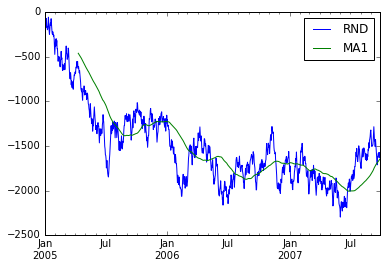

In [570]:
def Simulation_Data(period = 10000) :
    from numpy import log, cumsum
    from numpy.random import randn
    gbm = np.log(cumsum(randn(period)) + 1000)
    mr = np.log(randn(period) + 1000) + gbm[-1]
    tr = np.log(cumsum(randn(period) + 1) + 1000) 
    total = np.concatenate((gbm, mr, tr))

    return gbm, mr, tr, total

a,b,c,d = Simulation_Data()


import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
#yeah, simply roll dice
def roll_dice():
    roll = random.randrange(-100, 100)
    return roll

def mc_data(period = 1000) :
    x = 0
    result=0
    narr = []

    #roll it 1000 times
    while x < 1000:
        result += roll_dice()
        x+=1
        narr.append(result)

    #create fake data
    index_range = pd.date_range(start='2005-01-01', periods=period, freq='D') 
    narr_to_df = pd.DataFrame(narr, index=index_range, columns=["RND"])
    narr_to_df['MA1'] = pd.rolling_mean(narr_to_df['RND'], window=100)

    return narr_to_df
df_mc = mc_data(1000)
df_mc.plot()

MMI(GBM):   51.75035007
MMI(MR):    74.724944989
MMI(TR):    49.299859972
Hurst(GBM):   0.482869796498
Hurst(MR):    2.07607845453e-05
Hurst(TR):    0.900183155946


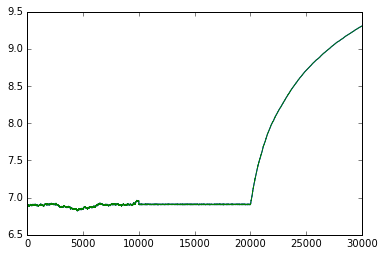

In [571]:
period = 10000
gbm = np.log(cumsum(randn(period)) + 1000)
mr = np.log(randn(period) + 1000) 
tr = np.log(cumsum(randn(period)+ 1) + 1000) 
total = np.concatenate((gbm, mr, tr))

plt.plot(total)
print "MMI(GBM):   %s" % MMI(gbm, len(gbm)-1)[-1]
print "MMI(MR):    %s" % MMI(mr, len(mr)-1)[-1]
print "MMI(TR):    %s" % MMI(tr, len(tr)-1)[-1]

print "Hurst(GBM):   %s" % hurst(gbm)
print "Hurst(MR):    %s" % hurst(mr)
print "Hurst(TR):    %s" % hurst(tr)

k, p = KStest(z_score(total, 50), 50)
plt.plot(total)

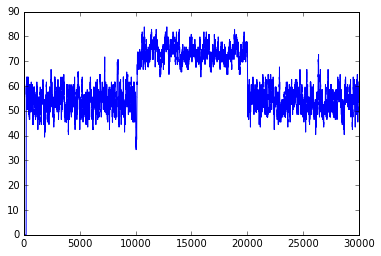

In [572]:
mmi = MMI(z_score(total,100), 100)
plt.plot(mmi)

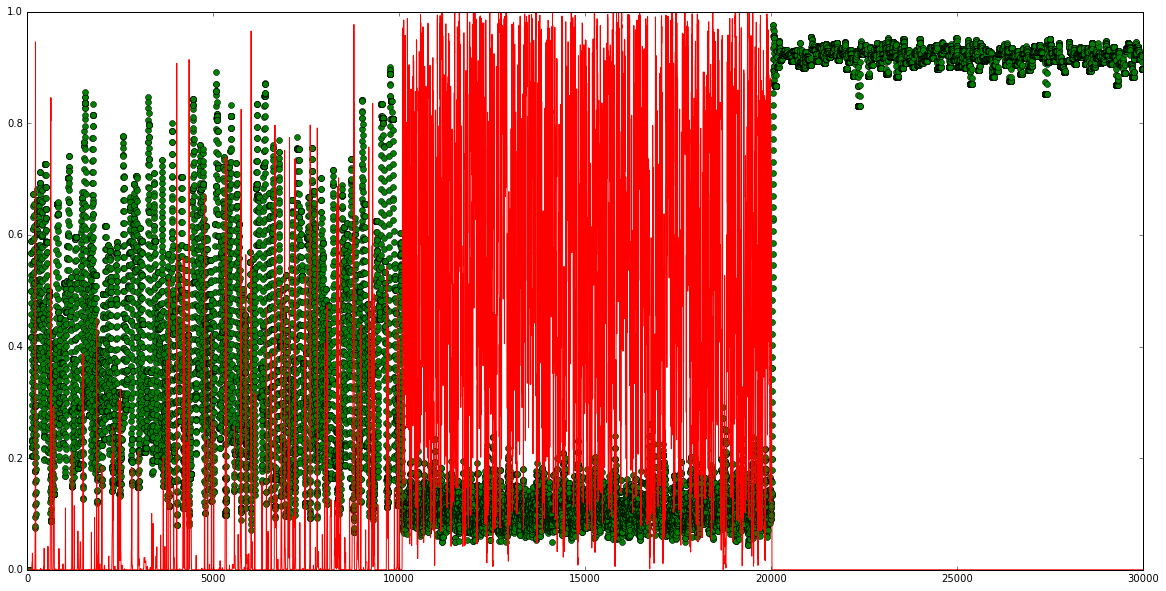

In [587]:
k, p = KStest(z_score(total, 50), 50)

plt.figure(figsize=[20,10])
plt.plot(k, 'go')
plt.plot(p, 'r')

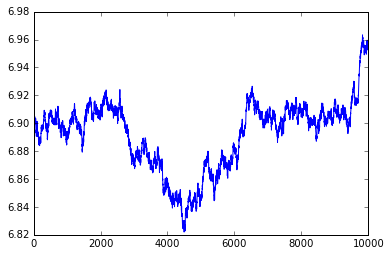

In [588]:
plt.plot(gbm)

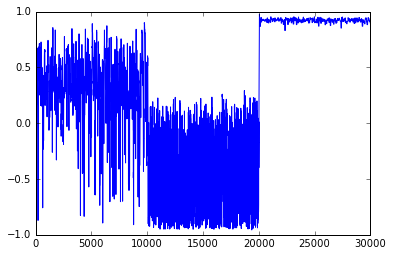

In [589]:
plt.plot(k - p)

In [609]:
adf_test = ts.adfuller(mr)
adf_test


def z_score(data, win) :
    me = ta.SMA(data, win)
    st = ta.STDDEV(data, win)
    return (data - me) / st

def KStest(data, period=100, side='two-sided') :
    k = np.zeros(len(data))
    p = np.zeros(len(data))
    
    for i in range(len(data)) :
        if i < period:
            continue
        data_in = data[(i-period+1):i]
        k[i], p[i] = stats.kstest(data_in, cdf='norm', alternative=side)
        
    return k, p

def ShapiroTest(data, period =100) :
    s = np.zeros(len(data))
    p = np.zeros(len(data))
    
    for i in range(len(data)):
        if i < period:
            continue
            
        data_in = data[(i-period+1):i]
        s[i], p[i] = stats.shapiro(data_in)
    return s, p
            

from scipy import stats
df['ret'] = df['close'].pct_change()
period = 500
ks_k, ks_p = KStest(z_score(df['ret'].values, period), period, 'less')
sh_s, sh_p = ShapiroTest(z_score(df['ret'].values, period), period)
df['ks_k'] = ks_k
df['ks_p'] = ks_p
df['sh_s'] = sh_s
df['sh_p'] = sh_p
df['ma'] = ZMA(df['close'].values, 200)

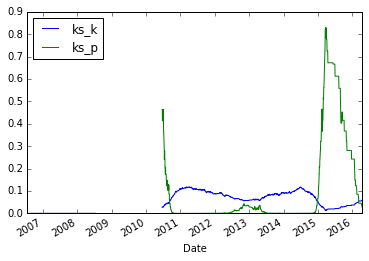

In [610]:
df[['ks_k', 'ks_p']].plot()

In [620]:
dict = df.to_dict()
df_c = dict['close']

dict

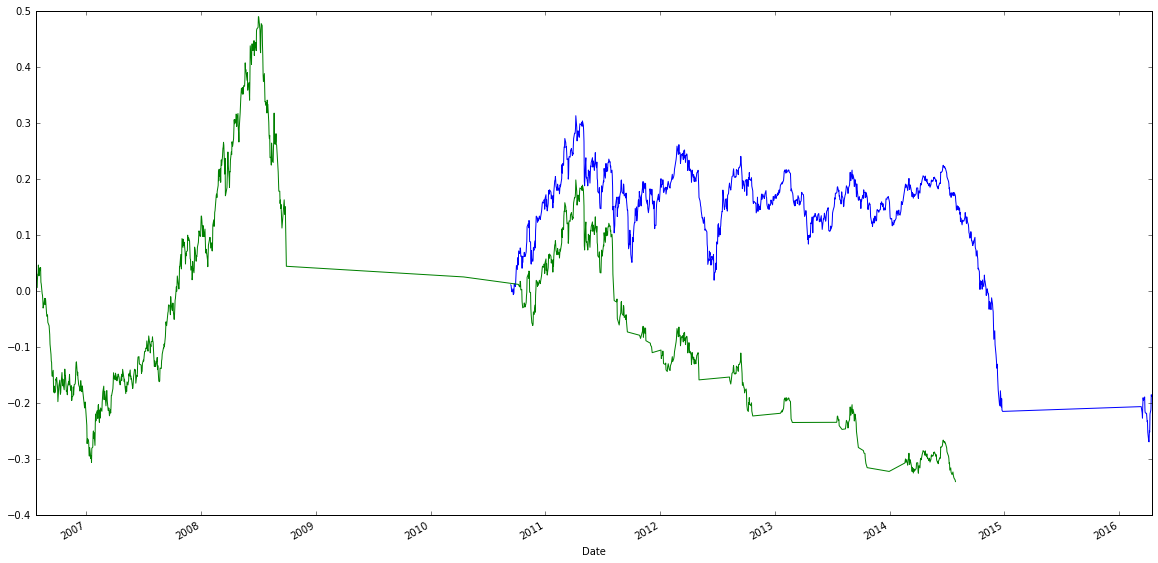

In [612]:
df['ret'][(df['ks_k'].shift(1) > (df['ks_p'].shift(1)+0.0))] \
    .cumsum().plot(figsize=[20,10])
df['ret'][(df['close'].shift(1) > df['ma'].shift(1))].cumsum().plot()

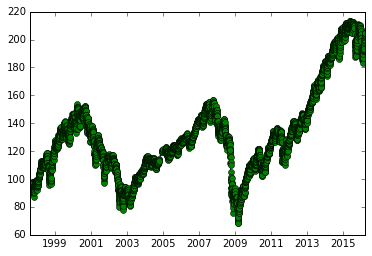

In [494]:
# df[['k', 'p']].plot(figsize=[20,10])
plt.plot(df['close'])
plt.plot(df['close'][df['sh_p'].shift(1) < 0.1],  'go')

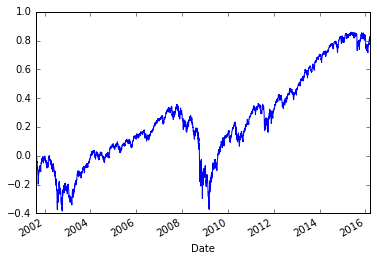

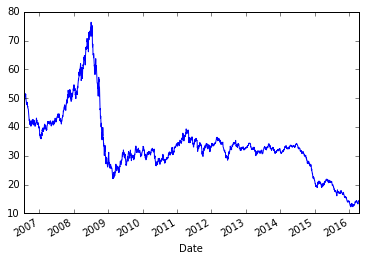

In [676]:
def TrendDeviation(data, length = 10) :
    '''
    TrendDeviation - the logarithmic closeing price , divided by the lowpass filtered price
    :param data:
    :param length:
    :return:
    '''
    lp = TrendIndicators.LowPass(data, length)
    return log(data/ lp)



def Momentum(data, length = 10) :
    '''
    Momentum - The price difference in n days, standardized by the volatility
    (close_0 - close_n)/stdev(close, n)
    :param df:
    :param length:
    :return:
    '''
    delta = ta.MOM(data, length)
    stdev = ta.STDDEV(data, length)

    return delta / stdev

df['TrendDev'] = TrendDeviation(df[['close']].values, 100)
df['Momentum'] = Momentum(df['close'].values, 100)
df['close'].plot()

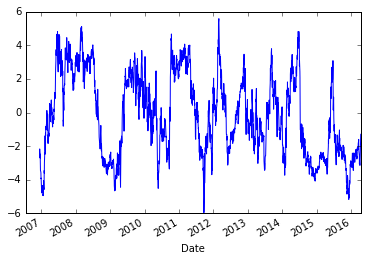

In [677]:
df['Momentum'].plot()

In [679]:
def MMI(data, period = 100) :
        mmi = np.zeros(data.shape)
        for i in range(len(data)) :
            if i < period - 1:
                continue

            m = np.median(data[(i-period + 1):i])
            nl = 0
            nh = 0
            for j in range(period-1):
                if j < 1:
                    continue
                if (data[i-j] > m) and (data[i-j] > data[i-j-1]) :
                    nl += 1
                if (data[i-j] < m) and (data[i-j] < data[i-j-1]) :
                    nh += 1
            mmi[i] = 100.0 * (nl+nh)/(period -1 )
        return mmi
    
def MMIDeviation(data, period = 100, n = 10):
        '''
        MMMDeviation = MMI_now - MMI_ndays_ago
        :param data:
        :param period:
        :param n: days ago to compare
        :return:
        '''
        mmi_0 = MMI(data, period)
        mmi_de = np.zeros(mmi_0.shape)

        for i in range(len(mmi_de)):
            if i < n :
                continue
            mmi_de[i] = mmi_0[i] - mmi_0[i - n]
            
        return mmi_de
    
def Hurst(data, period = 100) :
        from numpy import cumsum, log, polyfit, sqrt, std, subtract
        def hurst(ts):
            """Returns the Hurst Exponent of the time series vector ts"""
            # Create the range of lag values
            if 50 <= len(ts)  :
                n = 50
            else:
                n = len(ts)
            lags = range(2, 100)

            # Calculate the array of the variances of the lagged differences
            tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

            # Use a linear fit to estimate the Hurst Exponent
            poly = polyfit(log(lags), log(tau), 1)

            # Return the Hurst exponent from the polyfit output
            return poly[0]*2.0



        h = np.ones(data.shape) * 0.5
        for i in range(len(data)) :
            if i < period - 1:
                continue

            h[i] = hurst(data[(i-period+1):i])
        return h
    
def MMIDeviation(data, period = 100, n = 10):
        '''
        MMMDeviation = MMI_now - MMI_ndays_ago
        :param data:
        :param period:
        :param n: days ago to compare
        :return:
        '''
        mmi_0 = CycleIndicator.MMI(data, period)
        from scipy.ndimage.interpolation import shift
        mmi_n = shift(mmi_0, n, cval=np.NAN)
        return mmi_0 - mmi_n
    
a = Hurst(df[['close']].values, 500)
#b = MMIDeviation(df[['close']].values, 5, 1)
a = MMI(df[['close']].values, 100)
b = MMIDeviation(df[['close']].values, 100, 1)

In [680]:
a

array([[  0.        ],
       [  0.        ],
       [  0.        ],
       ..., 
       [ 48.48484848],
       [ 49.49494949],
       [ 49.49494949]])

In [685]:
from scipy.ndimage.interpolation import shift
b  = shift(a, 1, cval=np.NAN)
shift?

In [191]:
period = 100
#data = z_score(data, period).dropna()

ret  = data['close']
k = np.zeros(len(data))
p = np.zeros(len(data))
for i in range(len(data)) :
    if i < period:
        continue
    
    k[i], p[i] = stats.kstest(data['close'][(i-period+1):i].as_matrix().ravel(), cdf='norm')
k *10000

array([    0.        ,     0.        ,     0.        , ...,  4901.79604586,
        4901.79604586,  4901.79604586])

In [207]:
stats.kstest(df['volume'].values, cdf='norm')

KstestResult(statistic=0.99274898699082958, pvalue=0.0)

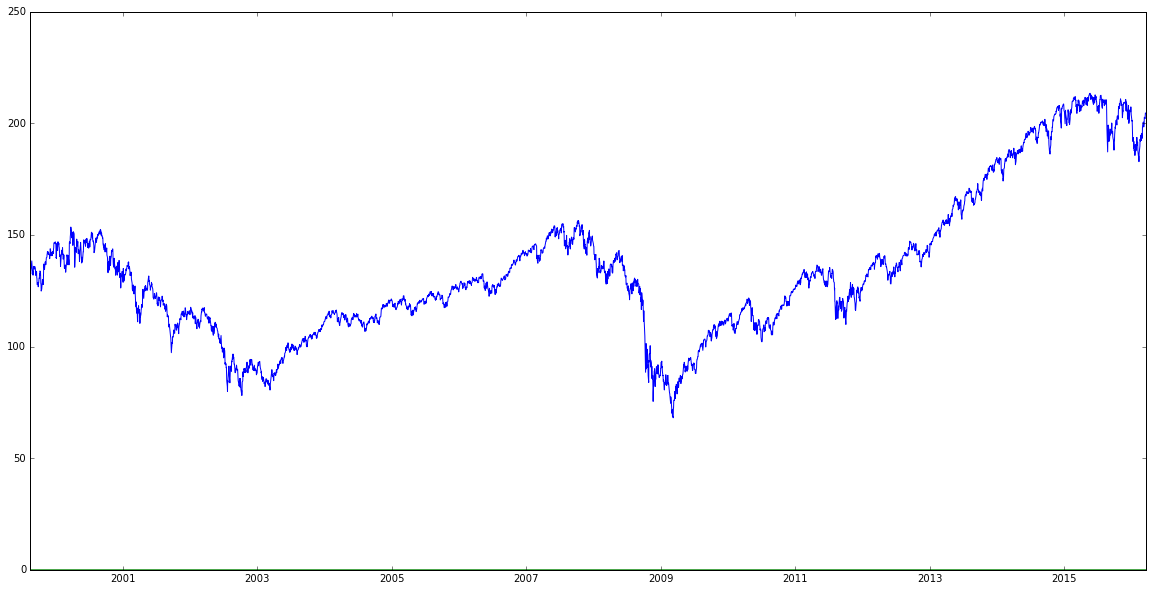

In [136]:
df_test1 = data
df_test1['k'] = k*100
df_test1['price'] = df[['close']]
#df_test1[['price', 'k']].plot(figsize=[20,10])

plt.figure(figsize=[20,10])
plt.plot(df_test1[['price']])
plt.plot(df_test1['k'])
plt.plot(df_test1['price'][df_test1['k'].shift(2) > 75], 'ro')

In [78]:
stats.kstest(data.as_matrix(), 'norm')

KstestResult(statistic=0.52083484619508791, pvalue=0.0)

In [208]:
np.random.seed(987654321)
stats.kstest(stats.t.rvs(100,size=100),'norm')

KstestResult(statistic=0.072018929165471257, pvalue=0.67630062862479168)

In [82]:
stats.t.rvs(100,size=100).shape
data.as_matrix().shape

(247, 1)

In [946]:
period = 60

# data = df[['close']].values.ravel()
df_gbm = pd.DataFrame(data=a, columns=['close'])
data = df_gbm.values.ravel()

ret = df_gbm[['close']].pct_change().fillna(0).values.ravel()


df_test = df_gbm[['close']].copy()

df_test['trend'] = SuperSmooth(data, period)
df_test['trend'] = ZMA(df_test['trend'].values, period)
p, v, pos_re, pos_tr = ExtremePoints(df_test['trend'].values)


df_test['peak'] = p
df_test['valley'] = v
df_test['pos_re'] = pos_re
df_test['pos_tr'] = pos_tr
df_test['mmi'] = MMI(data, period)
df_test['ret'] = ret
df_test.tail()

,close,trend,peak,valley,pos_re,pos_tr,mmi,ret
2995,8.586001,8.506898,0,0,1,0,52.542373,-0.004436
2996,8.551456,8.508280,0,0,1,0,52.542373,-0.004023
2997,8.522518,8.509678,0,0,1,0,54.237288,-0.003384
2998,8.526952,8.511092,0,0,1,0,54.237288,0.000520
2999,8.542074,8.512516,0,0,0,0,54.237288,0.001774


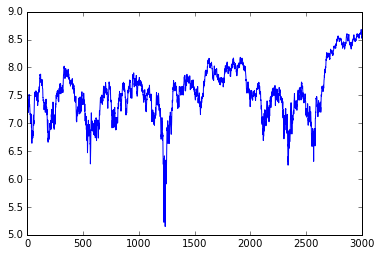

In [947]:
df_test['close'].plot()

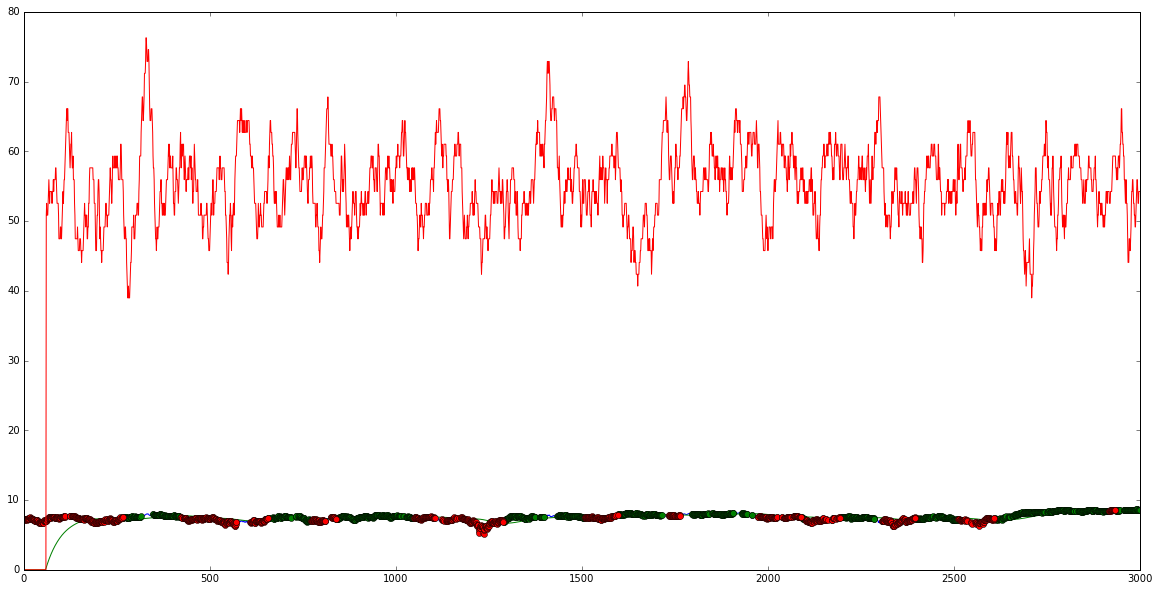

In [948]:
import matplotlib.pyplot as plt
df_test1 = df_test #['2006-01-01':'2016-01-01']
plt.figure(figsize=[20, 10])
plt.plot(df_test1['close'])
plt.plot(df_test1['trend'])
plt.plot(df_test1['close'][df_test1['pos_re'].shift(1)==1][df_test1['mmi'] < 60], 'go')
plt.plot(df_test1['close'][df_test1['pos_re'].shift(1)==0][df_test1['mmi'] < 60], 'ro')


# plt.plot(df_test1['close'][df_test1['pos_tr'].shift(1)==1][df_test1['mmi'] > 60], 'go')
# plt.plot(df_test1['close'][df_test1['pos_tr'].shift(1)==0][df_test1['mmi'] > 60], 'ro')


# plt.plot(df_test1['close'][df_test1['valley'].shift(1)==1][df_test1['mmi'] > 60], 'ro')
# plt.plot(df_test1['close'][df_test1['peak'].shift(1)==1][df_test1['mmi'] > 60], 'ro')
# plt.plot(df_test1['close'][df_test1['valley'].shift(1)==1][df_test1['mmi'] > 60], 'go')
plt.plot(df_test1['mmi'])

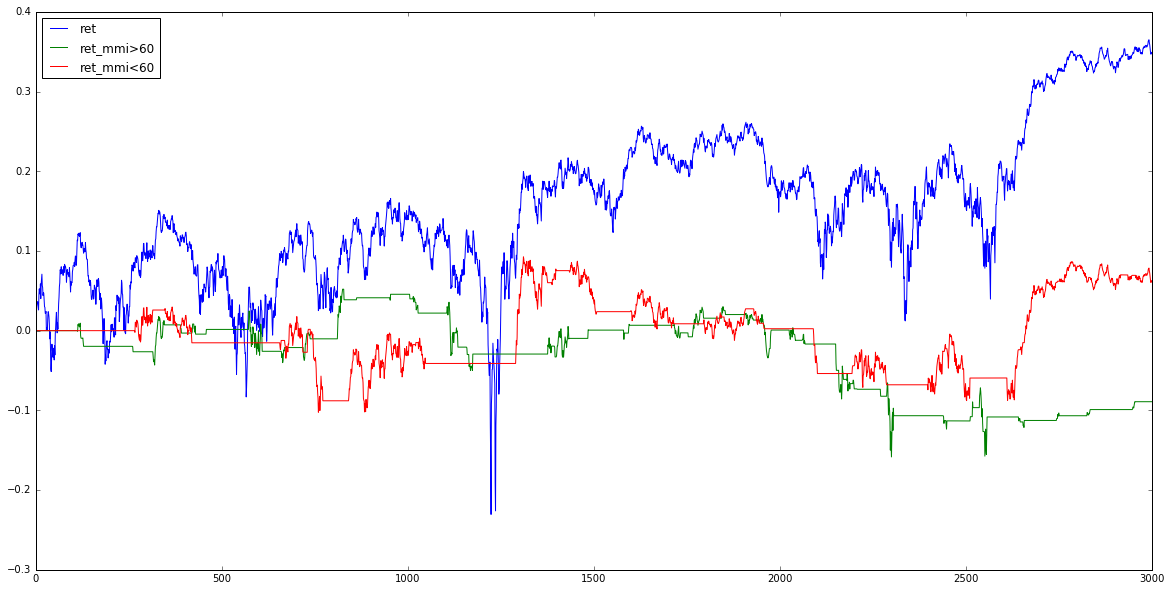

In [949]:
df_test1['long'] = (df_test1['pos_re'].shift(1)==1)*(df_test1['mmi'] < 60)
df_test1['short'] = (df_test1['pos_re'].shift(1)==0)*(df_test1['mmi'] < 60)
df_test1['ret_long'] = df_test1['ret'] * (df_test1['pos_re'].shift(1) == 1).shift(1)
df_test1['ret_short'] = df_test1['ret'] * (df_test1['pos_re'].shift(1) == 0).shift(1)
df_test1['ret_mmi<60'] = df_test1['ret'] * ((df_test1['pos_re'].shift(1) == 1)*(df_test1['mmi'] < 60)).shift(1)
df_test1['ret_mmi>60'] = df_test1['ret'] * (df_test1['mmi'] > 60).shift(1)

df_test1[['ret','ret_mmi>60', 'ret_mmi<60']].cumsum().plot(figsize=[20,10])

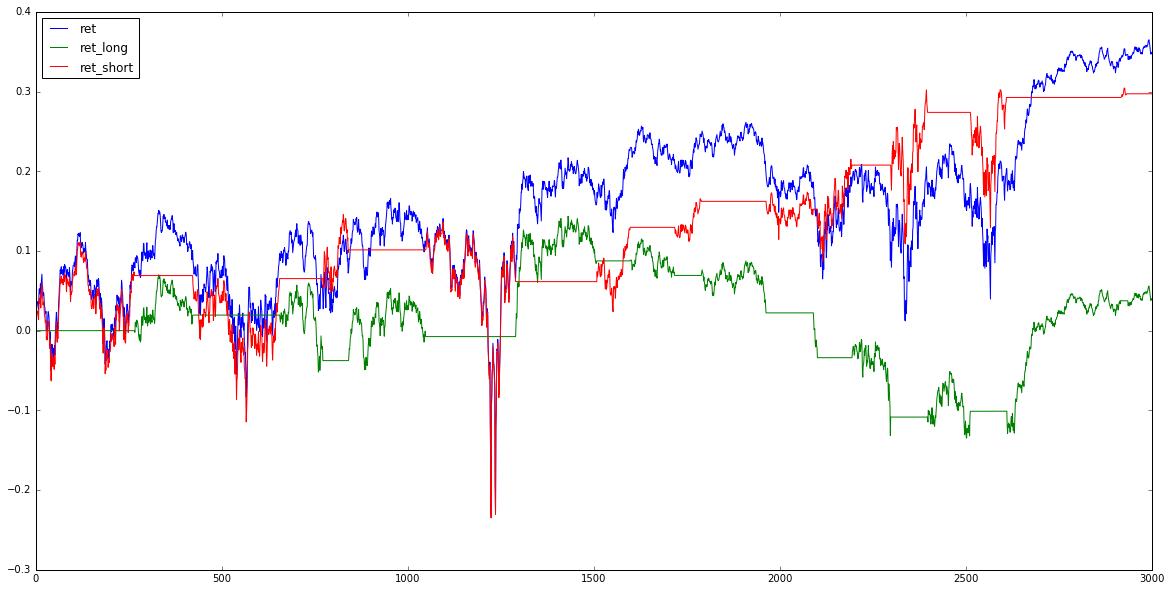

In [950]:
df_test1[['ret', 'ret_long', 'ret_short']].cumsum().plot(figsize=[20,10])

In [788]:
# def ImpluseTest():
period = 150
impluse = np.concatenate((np.zeros([200,1]), np.ones([20,1]), np.zeros([20,1]), np.ones([20,1]), np.zeros([20,1]),np.ones([20,1]), np.zeros([20,1]),np.ones([20,1]), np.zeros([20,1]), np.zeros([200,1])), axis=0)
df_lp = pd.DataFrame(data=impluse, columns=['close'])
df_lp['lpass'] = LowPass(impluse, period)
df_lp['alma'] = ALMA(impluse, period)
# df_lp = df_lp.join(ZMA(df_im, period))
#df_lp['EMA'] = ta.EMA(df_im['close'].values.ravel(), period)
df_lp['ssmooth'] = SuperSmooth(impluse, period)
df_lp['zma'] = ZMA(impluse, period)
# df_lp['decycler'] = Decycler(impluse, period)
df_lp.plot(figsize=[20,10])

AssertionError: real has wrong dimensions

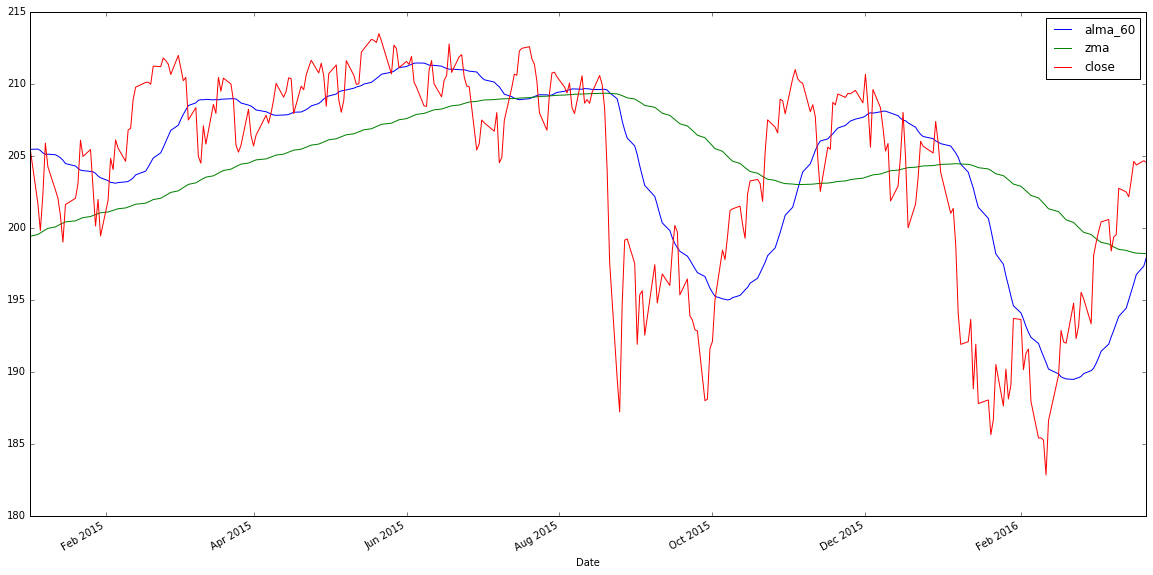

In [361]:
df_alma = ALMA(df, period)
df_alma['zma'] = ZMA(df, period)
df_alma['close'] = df['close']
df_alma['2015-01-01'::].plot(figsize=[20,10])

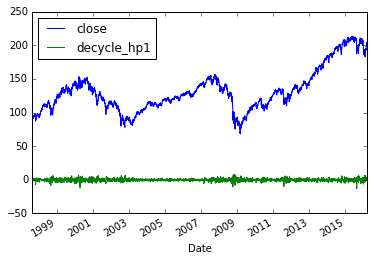

In [324]:
df_decycle_osc = DecyclerOsc(df)
df_decycle_osc[['close', 'decycle_hp1']].plot()

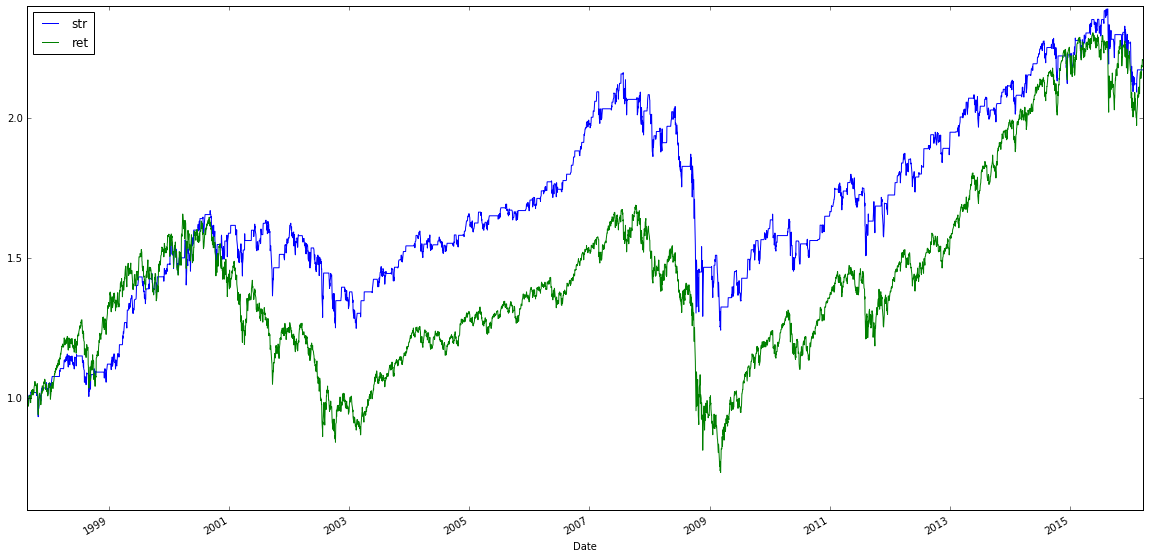

In [301]:
df_de = DecyclerOsc(df, 10, 60)

df_de['ret'] = df[['close']].pct_change()
df_de['str'] = df_de['ret'] * (df_de['decycle_osc'] < 0).shift(1) 
(1+df_de[['str', 'ret']]).cumprod().plot(figsize=[20,10])

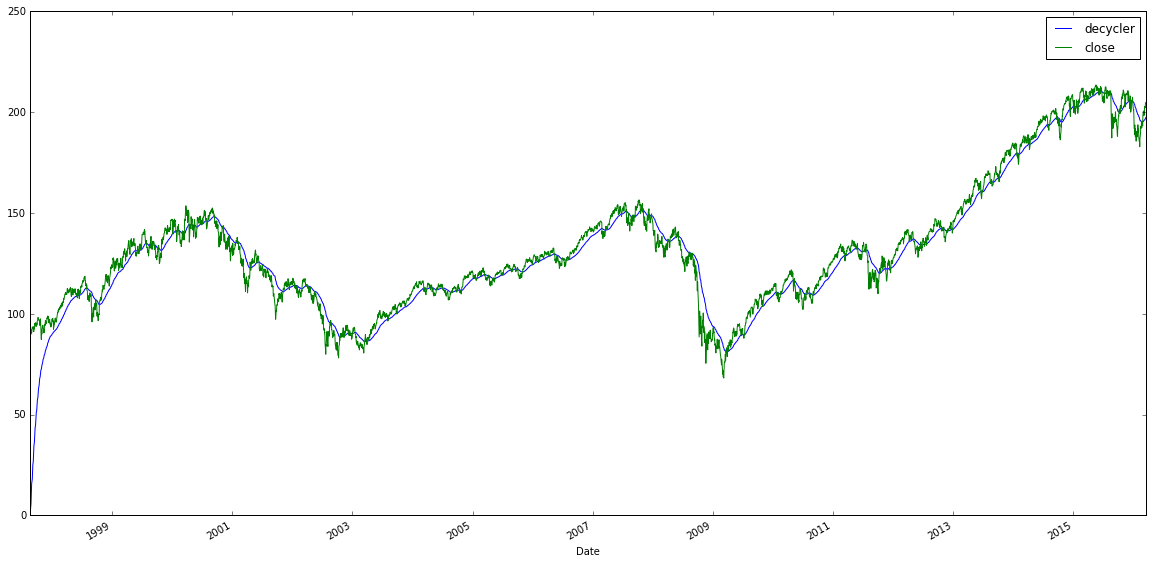

In [322]:
Decycler(df, 200).plot(figsize=[20,10])

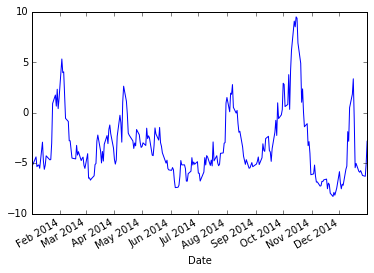

In [311]:
(df_decycle.iloc[:,0] - df_decycle.iloc[:,1])['2014-01-01':'2015-01-01'].plot()

In [219]:
alpha1

-0.33248811797985672

In [182]:
HP2

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [70]:
price= df['price'].values
rsi  = ta.RSI(price, 3)
df['rsi'] = rsi
df['sma'] = ta.SMA(price, 3)
df.head()

,open,high,low,close,volume,price,rsi,sma
Date,,,,,,,,
2010-01-01 00:00:00+00:00,112.23,112.65,112.17,111.44,0,111.44,NaN,NaN
2010-01-04 00:00:00+00:00,112.37,113.39,111.51,113.33,118944541,113.33,NaN,NaN
2010-01-05 00:00:00+00:00,113.26,113.68,112.85,113.63,111579866,113.63,NaN,112.800000
2010-01-06 00:00:00+00:00,113.52,113.99,113.43,113.71,116074402,113.71,100,113.556667
2010-01-07 00:00:00+00:00,113.50,114.33,113.18,114.19,131091048,114.19,100,113.843333


In [608]:
if __name__  == "__main__" :
    tickers = ['GOOG/AMEX_GSG']

    settings = Settings()
    dp = TimeSeries(settings).get_agg_ETF_data(tickers)
    dp = dp.fillna(method='pad', axis=0)
    dp = dp.fillna(method='bfill', axis=0)
#     dp = dp[:,'2010-01-01'::,:]
    dp = dp.dropna()
    
    df = pd.DataFrame(index=dp.axes[1])
    for col in dp.axes[2] :
        df[col] = dp[:, :, col]

    dp1 = dp.reindex_axis(['open', 'high', 'low', 'close', 'volume', 'price'], axis=2)

    
#     rets = pd.DataFrame()
#     nn = [2, 5, 10, 20, 50]
#     #nn = [50, 100]
#     for n in nn:
#         print "running {n}".format(n=n)
#         rets['nn={n}'.format(n=n)] = TestNN(dp1).set_params(30, n).run_trading().portfolio_value
#         rets.plot(figsize=[20,12])
    

#     print 'done!'

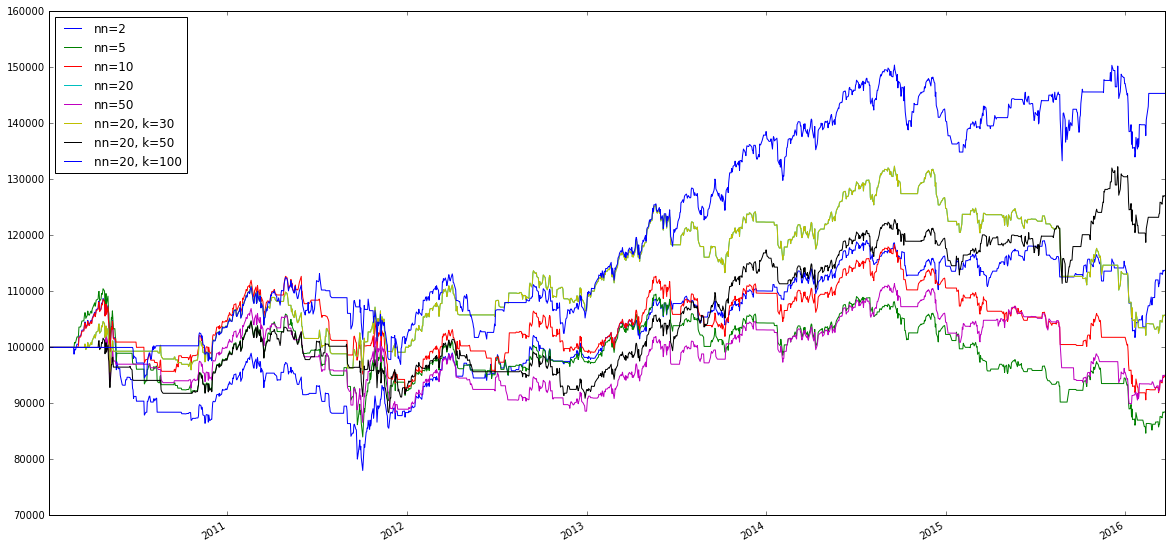

In [3]:
k = [30, 50, 100]
rets['nn=20, k=30'] = rets['nn=20']
rets['nn=20, k=50'] = TestNN(dp1).set_params(50, 20).run_trading().portfolio_value
rets['nn=20, k=100'] = TestNN(dp1).set_params(100, 20).run_trading().portfolio_value

rets.plot(figsize=[20,10])

predict 1.0
predict 1.0
predict 1.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 1.0
predict 1.0
predict 0.0
predict 1.0
predict 0.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 0.0
predict 1.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
pred

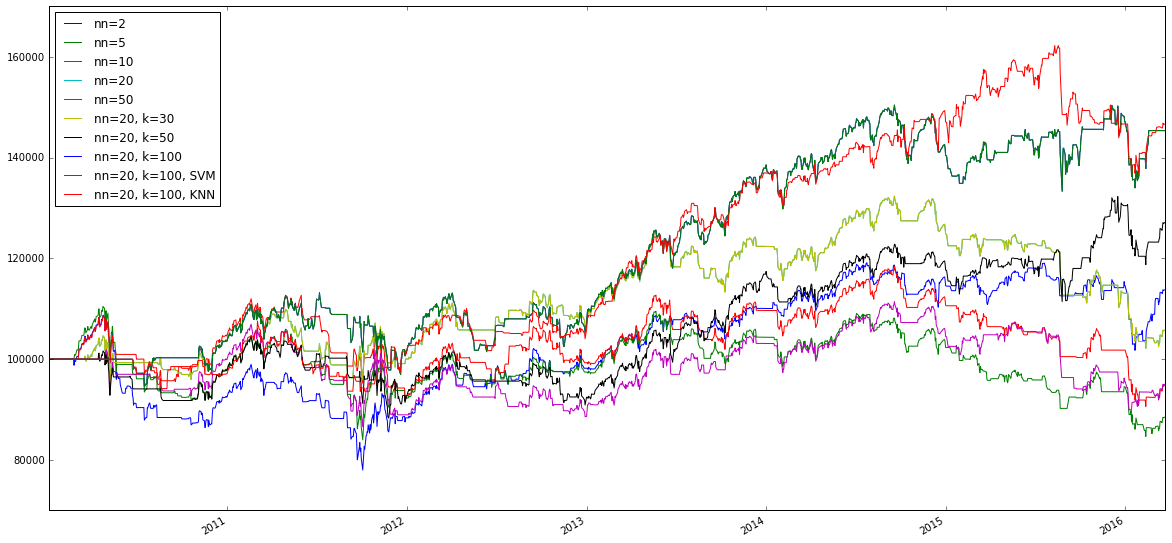

In [15]:
rets['nn=20, k=100, SVM'] = rets['nn=20, k=100']
rets['nn=20, k=100, KNN'] = TestNN(dp1).set_params(100, 20, 'KNN').run_trading().portfolio_value
rets.plot(figsize=[20,10])

In [28]:
NN = [2, 5, 10]
K = [100]
ML = ['SVM', 'KNN']
for n in NN:
    for k in K:
        for m in ML:
            label = 'nn={n}, k={k}, m={m}'.format(n=n, k=k, m=m)
            print label
            rets[label] = TestNN(dp1).set_params(k, n, m).run_trading().portfolio_value

nn=2, k=100, m=SVM
nn=2, k=100, m=KNN
nn=5, k=100, m=SVM
nn=5, k=100, m=KNN
nn=10, k=100, m=SVM
nn=10, k=100, m=KNN


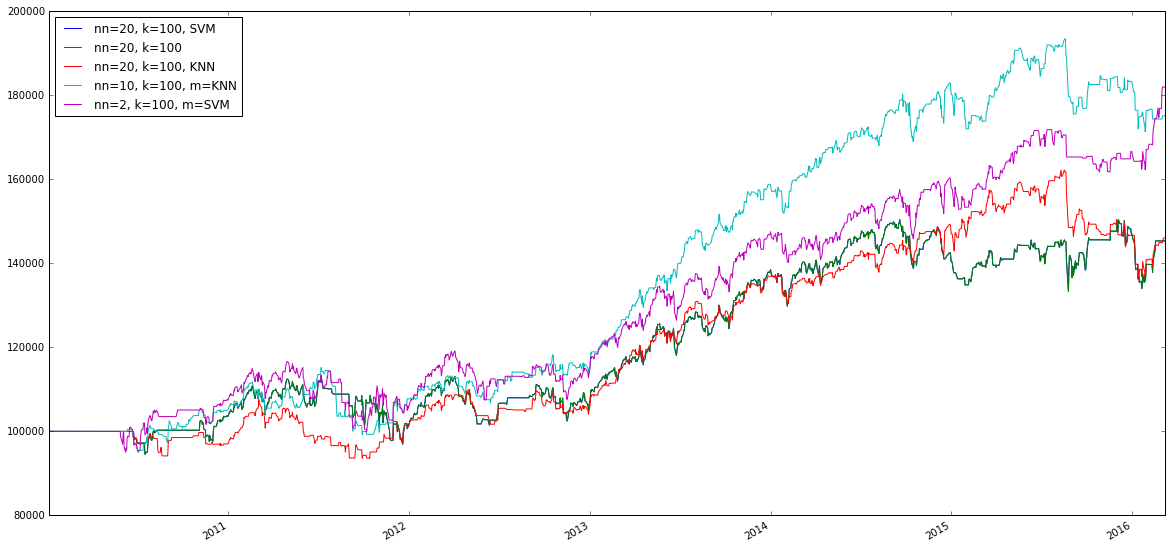

In [72]:
rets = rets.iloc[:-1, :]
max_order = np.argsort(rets.iloc[-1, :].values)
rets.iloc[:, max_order[(len(max_order)-5):]].plot(figsize=[20,10])

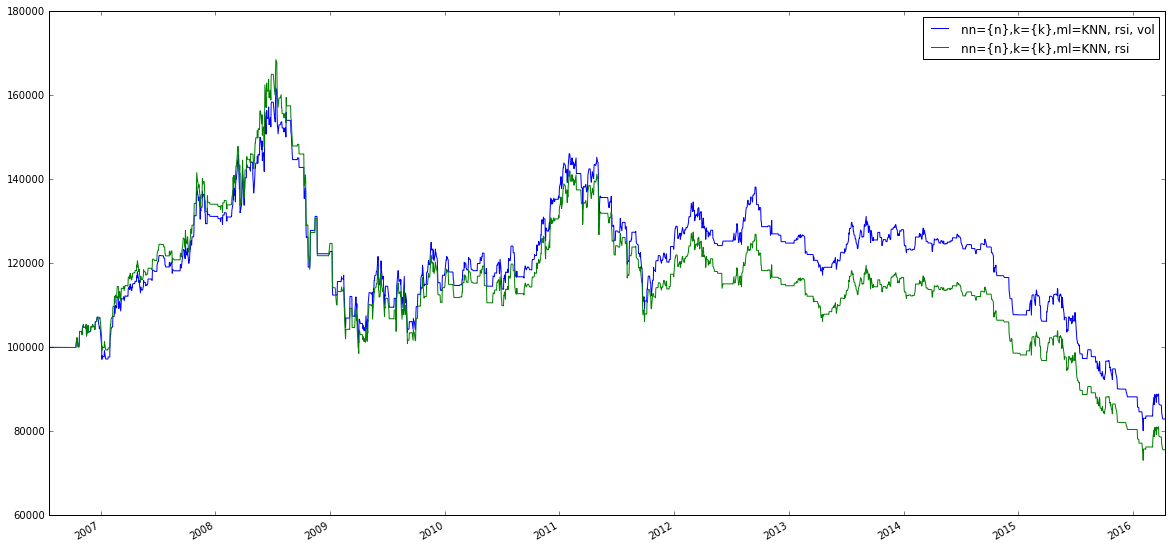

In [688]:
### Test with RSI and Vol
rets_1 = pd.DataFrame()
rets_1['nn={n},k={k},ml=KNN, rsi, vol'] = TestNN(dp1).set_params(30, 10, ml='KNN', rsi=True, vol=True). \
    run_trading().portfolio_value
rets_1['nn={n},k={k},ml=KNN, rsi'] = TestNN(dp1).set_params(30, 10, ml='KNN', rsi=True, vol=False). \
    run_trading().portfolio_value
rets_1.plot(figsize=[20, 10])